In [352]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

In [195]:
data_dir = 'data/'
images_dir = data_dir + "images"
train_images_dir = data_dir + "train"
val_images_dir = data_dir + "val"
test_images_dir = data_dir + "test"

In [163]:
np.random.seed(0)

In [164]:
all_raw_train_data = pd.read_csv(data_dir + "train.csv")

msk = np.random.rand(len(all_raw_train_data)) < 0.7

train_data = all_raw_train_data[msk]
val_data = all_raw_train_data[~msk]

In [165]:
# Создает папки для классов по выборке.
def create_class_folder(df_data, source_dir: str, dest_dir: str):
    for data_id, data_class in zip(df_data.id, df_data.species):
        try:
            shutil.copyfile("/".join((source_dir, str(data_id) + ".jpg")), 
                        "/".join((dest_dir, data_class, str(data_id) + ".jpg")))
        except FileNotFoundError:
            os.mkdir("/".join((dest_dir, data_class)))

In [166]:
# Создает папки для классов для обуч-выборки
create_class_folder(train_data, images_dir, train_images_dir)

In [167]:
# Создает папки для классов для вал-выборки.
create_class_folder(val_data, images_dir, val_images_dir)

In [193]:
val_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': val_transforms,
}


image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

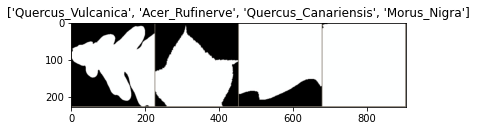

torch.Size([4, 3, 224, 224])

In [214]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

inputs.shape

In [170]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # По всем данным.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Статистика
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model

In [171]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [184]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Оптимизируются все параметры
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Уменьшение скорости обучения на каждом 7 шаге
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [185]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.5484 Acc: 0.0315
val Loss: 3.6063 Acc: 0.1447

Epoch 1/24
----------
train Loss: 3.8153 Acc: 0.0976
val Loss: 2.4452 Acc: 0.2766

Epoch 2/24
----------
train Loss: 3.3389 Acc: 0.1710
val Loss: 1.8610 Acc: 0.4799

Epoch 3/24
----------
train Loss: 3.0392 Acc: 0.2141
val Loss: 1.7734 Acc: 0.4945

Epoch 4/24
----------
train Loss: 2.8106 Acc: 0.2655
val Loss: 1.5951 Acc: 0.4725

Epoch 5/24
----------
train Loss: 2.6602 Acc: 0.2865
val Loss: 1.5728 Acc: 0.4689

Epoch 6/24
----------
train Loss: 2.5009 Acc: 0.3106
val Loss: 1.3326 Acc: 0.5568

Epoch 7/24
----------
train Loss: 2.2506 Acc: 0.3987
val Loss: 1.0099 Acc: 0.6612

Epoch 8/24
----------
train Loss: 2.1318 Acc: 0.4397
val Loss: 0.9088 Acc: 0.7143

Epoch 9/24
----------
train Loss: 2.0579 Acc: 0.4491
val Loss: 0.9250 Acc: 0.6923

Epoch 10/24
----------
train Loss: 2.0422 Acc: 0.4533
val Loss: 0.9316 Acc: 0.7051

Epoch 11/24
----------
train Loss: 1.9742 Acc: 0.4858
val Loss: 0.8584 Acc: 0.7344

Ep

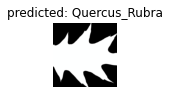

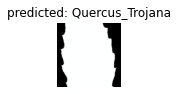

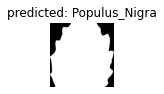

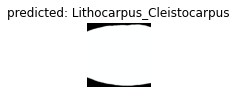

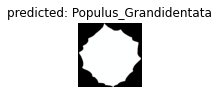

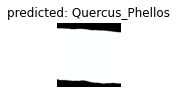

In [186]:
visualize_model(model_ft)

## Меняются параметры только финального слоя

In [187]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, len(class_names))

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Оптимизируется только последний слой
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [188]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7472 Acc: 0.0210
val Loss: 4.1050 Acc: 0.0989

Epoch 1/24
----------
train Loss: 4.3957 Acc: 0.0409
val Loss: 3.4600 Acc: 0.1410

Epoch 2/24
----------
train Loss: 4.1145 Acc: 0.0714
val Loss: 2.9078 Acc: 0.2875

Epoch 3/24
----------
train Loss: 3.9310 Acc: 0.1049
val Loss: 2.5593 Acc: 0.3297

Epoch 4/24
----------
train Loss: 3.7662 Acc: 0.1196
val Loss: 2.2986 Acc: 0.3736

Epoch 5/24
----------
train Loss: 3.5767 Acc: 0.1427
val Loss: 2.1377 Acc: 0.3810

Epoch 6/24
----------
train Loss: 3.4781 Acc: 0.1668
val Loss: 1.9712 Acc: 0.4341

Epoch 7/24
----------
train Loss: 3.2453 Acc: 0.2361
val Loss: 1.7239 Acc: 0.5513

Epoch 8/24
----------
train Loss: 3.1668 Acc: 0.2613
val Loss: 1.6991 Acc: 0.5897

Epoch 9/24
----------
train Loss: 3.1562 Acc: 0.3043
val Loss: 1.6610 Acc: 0.5879

Epoch 10/24
----------
train Loss: 3.0809 Acc: 0.3116
val Loss: 1.5919 Acc: 0.6062

Epoch 11/24
----------
train Loss: 3.0944 Acc: 0.2865
val Loss: 1.6075 Acc: 0.6319

Ep

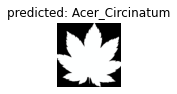

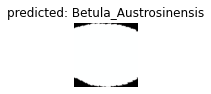

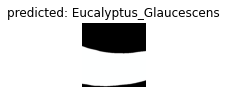

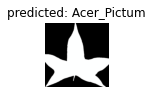

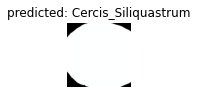

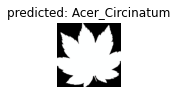

In [189]:
visualize_model(model_conv)

plt.ioff()
plt.show()

(383, 594)

In [270]:
image1 = Image.open(test_images_dir + "/4.jpg")
image1.size

test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image1 = image1.convert(mode='RGB')
image1 = test_transforms(image1)
image1 = image1.unsqueeze(0)
image1.shape

torch.Size([1, 3, 224, 224])

In [389]:
output1 = model_conv(image1)
_, preds = torch.max(output1, 1)

In [371]:
m = nn.Sigmoid()
meh = m(output1)
meh

tensor([[0.2232, 0.0654, 0.2110, 0.9776, 0.0173, 0.1235, 0.8528, 0.2368, 0.3636,
         0.3070, 0.9503, 0.0944, 0.9224, 0.0800, 0.8754, 0.0082, 0.1398, 0.6230,
         0.0604, 0.4423, 0.5883, 0.4712, 0.1390, 0.5636, 0.0880, 0.4985, 0.2109,
         0.9085, 0.0248, 0.1566, 0.2180, 0.6055, 0.8575, 0.7718, 0.5026, 0.0450,
         0.9583, 0.2399, 0.1059, 0.2746, 0.3472, 0.2748, 0.3945, 0.1099, 0.4460,
         0.9977, 0.9975, 0.0715, 0.0898, 0.0088, 0.7170, 0.9998, 0.9964, 0.5467,
         0.8453, 0.3842, 0.5548, 0.0520, 0.9508, 0.7222, 0.6632, 0.7150, 0.9937,
         0.5221, 0.9959, 0.5861, 0.9090, 0.2404, 0.5131, 0.1933, 0.3605, 0.1434,
         0.0127, 0.8098, 0.5512, 0.9101, 0.0375, 0.0514, 0.1894, 0.9985, 0.5719,
         0.8987, 0.5043, 0.9998, 0.2244, 0.0651, 0.4060, 0.1199, 0.0304, 0.0070,
         0.0181, 0.9406, 0.9275, 0.6722, 0.9514, 0.0500, 0.9779, 0.2459, 0.1259]],
       grad_fn=<SigmoidBackward0>)

In [373]:
raw_test_data = pd.read_csv(data_dir + "test.csv")

In [382]:
test_data_result = pd.DataFrame(columns=["id", *class_names])
test_data_result

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata


In [383]:
sigmoid_func = nn.Sigmoid()

In [384]:
for idx in raw_test_data.id:
    test_image = Image.open("/".join((images_dir, str(idx) + ".jpg")))
    
    test_image = test_image.convert(mode='RGB')
    test_image = test_transforms(test_image)
    test_image = test_image.unsqueeze(0)
    
    test_output = model_ft(test_image)
    
    test_output = sigmoid_func(test_output)
    test_output = test_output.flatten(0)

    test_output = test_output.tolist()
    
    temp_dict = dict(zip(class_names, test_output))
    temp_dict["id"] = idx
            
    test_data_result.loc[len(test_data_result)] = temp_dict


In [385]:
test_data_result

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.021394,0.011951,0.133309,0.925576,0.000989,0.370268,0.927834,0.073189,1.388106e-01,...,0.025810,0.014751,0.825354,0.905679,0.297463,0.889775,0.009878,0.998824,0.341652,0.024547
1,7,0.026123,0.013471,0.017680,0.103798,0.000657,0.052147,0.465320,0.024965,4.619213e-04,...,0.921566,0.189817,0.007977,0.996198,0.052929,0.766085,0.035153,0.004729,0.478574,0.566700
2,9,0.913394,1.000000,0.985224,0.999938,0.999960,0.969351,0.997422,0.999959,9.826868e-01,...,0.008985,0.013719,0.124661,0.970723,0.946263,0.949334,0.893054,0.084624,0.817635,0.989174
3,12,0.084251,0.033851,0.000048,0.002745,0.035738,0.560388,0.968002,0.048814,4.784122e-07,...,0.309879,0.004343,0.009258,0.998955,0.798102,0.998869,0.060318,0.032805,0.413761,0.995035
4,13,0.626413,0.326001,0.059360,0.013565,0.337366,0.004972,0.013888,0.001217,9.993711e-01,...,0.017621,0.580464,0.961475,0.997081,0.938750,0.997674,0.999228,0.744971,0.080359,0.057815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,0.853371,1.000000,0.975610,0.999582,0.999989,0.983592,0.987956,0.999804,8.761317e-01,...,0.067113,0.039488,0.045939,0.921866,0.842517,0.829602,0.767605,0.077968,0.886579,0.975436
590,1577,0.943424,0.092227,0.069511,0.968863,0.010659,0.005647,0.006172,0.999914,9.945874e-01,...,0.013058,0.207168,1.000000,0.846814,0.999937,0.999909,0.940242,0.819357,0.972699,0.858531
591,1579,0.598283,0.113823,0.758552,0.874935,0.000050,0.107706,0.021811,0.219729,5.174725e-03,...,0.117711,0.012456,0.082577,0.549941,0.134182,0.084642,0.013839,0.035583,0.725718,0.999906
592,1580,0.586430,0.492505,0.473223,0.723196,0.484491,0.370801,0.003331,0.037865,9.219600e-01,...,0.004279,0.794806,0.987111,0.931296,0.885219,0.634513,0.932826,0.996249,0.317014,0.139979


In [386]:
test_data_result.to_csv("submission.csv", index=False)